In [ ]:
'''
2020년 9월에 계정이 생성 된 유저에 국한하여 Conversion Rate 게산.
- 대상 9월에 계정을 생성한 유저 전체.
- 목표 전환 행동: 구매.
- 대상 데이터: user.csv & payment.csv
- 계산 방법: 2020년 9월에 계정을 생성한 후 구매한 유저 수[일별, 주별, 월 전체]/2020년 9월에 계정을 생성한 유저 전체[일별, 주별, 월 전체],
- 분석 내용: 일별, 주별, 월별 전환 분석
'''

In [2]:
# 필요 라이브러리 import.
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt
import math
import datetime
%matplotlib inline

In [3]:
# user.csv와 paymnet.csv 로드.
users = pd.read_csv('/home/mlhacker/Downloads/DS_assignment/data/linux/user.csv')
payment = pd.read_csv('/home/mlhacker/Downloads/DS_assignment/data/linux/payment.csv')

In [4]:
# 레코드 수 확인
len(users)

23730

In [5]:
len(payment)

7308

In [6]:
# 로딩된 데이터 확인.
users.head()

,user_idx,status,third_party_join_type,joined_date
0,1a7fc929c6e372920f0f22d4fe43d4f25e15e965774a5e...,0,NaN,2019-08-10T01:01:09.000+09:00
1,dfd21a2faa82692cd0e5bfeb17454c27e9888819987076...,0,NaN,2020-08-04T01:24:36.000+09:00
2,e3e7e5954b5b1d7fd7d6a6189ca7ec055d41ee8397fb60...,0,NaN,2020-10-04T12:10:50.000+09:00
3,9f32f315adf23ca786593270a2e7d8ee30e997660b2455...,0,NaN,2019-11-28T01:00:36.000+09:00
4,12848af86c016225423b324cb20f7c74ab608a7b978b0e...,0,NaN,2020-09-13T17:21:46.000+09:00


In [7]:
payment.head()

,user_idx,subscription_type,cart_discount_price,order_shipping_price,order_total_price,paid_date
0,0973f573635c1b55a58f1d221f992bfeb0b3e007a93efb...,구독,5100,3000,12900,2020-10-21
1,305181c0babb5077b46ccb298a41469729a6760b19e44d...,구독,5100,3000,12900,2020-10-09
2,5fa450bdb2e831617f0132293d63638e0f93f1f62af4ca...,구독,5100,3000,12900,2020-10-11
3,85649b91d8ac8d2e84faa6c54032254356fe02c69d5fa0...,구독,5100,3000,12900,2020-10-14
4,05afd1abc70fce9afaa18482a0bb9c6cb082e65b1e0ab4...,구독,5100,3000,12900,2020-10-21


In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23730 entries, 0 to 23729
Data columns (total 4 columns):
user_idx                 23730 non-null object
status                   23730 non-null int64
third_party_join_type    2379 non-null object
joined_date              23730 non-null object
dtypes: int64(1), object(3)
memory usage: 741.6+ KB


In [9]:
payment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7308 entries, 0 to 7307
Data columns (total 6 columns):
user_idx                7308 non-null object
subscription_type       7277 non-null object
cart_discount_price     7308 non-null int64
order_shipping_price    7308 non-null int64
order_total_price       7308 non-null int64
paid_date               7308 non-null object
dtypes: int64(3), object(3)
memory usage: 342.6+ KB


In [10]:
# 날짜 속성 값을 이용하기 위해 현재 스트링으로 된 속성 값을 datetime 값으로 변경.
users['joined_date'] = pd.to_datetime(users['joined_date'])

In [11]:
# 9월에 계정을 생성한 사용자 확인.
users['month'] = users['joined_date'].dt.month
users['year'] = users['joined_date'].dt.year
users['day'] = users['joined_date'].dt.day
users['weekofmonth'] = (users['day']-1) // 7 + 1    # 그달의 주[1,2,3,4,5].

In [12]:
# 전제 유저 데이터에 월 속성 값이 제대로 삽입 된 것인지 확인.
users['month'].unique()

array([ 8, 10, 11,  9,  7,  4,  5,  6, 12,  3,  2,  1])

In [13]:
# 전제 유저 데이터에 년 속성 값이 제대로 삽입 된 것인지 확인.
users['year'].unique()

array([2019, 2020])

In [14]:
# 전제 유저 데이터에 일자 속성 값이 제대로 삽입 된 것인지 확인.
users['day'].unique()

array([10,  4, 28, 13, 12, 14,  7,  6, 17, 20, 19, 23,  5,  3, 11, 22, 29,
       30, 24, 21,  2, 15, 26, 16, 25,  1, 31, 27,  8,  9, 18])

In [15]:
# 전제 유저 데이터에 주 속성 값이 제대로 삽입 된 것인지 확인.
users['weekofmonth'].unique()

array([2, 1, 4, 3, 5])

In [16]:
# user.csv로 부터 2020년 9월에 계정을 생성한 유저 데이터 수집.
september_users = users[(users['month'] == 9) & (users['year'] == 2020)]

In [17]:
# 2020년 9월에 계정을 생성한 유저 수 확인.
len(september_users)

2979

In [18]:
# user.csv로 부터 수집된 2020년 9월 유저 데이터 확인.
september_users.head()

,user_idx,status,third_party_join_type,joined_date,month,year,day,weekofmonth
4,12848af86c016225423b324cb20f7c74ab608a7b978b0e...,0,NaN,2020-09-13 17:21:46+09:00,9,2020,13,2
15,7a5df8771c0599ddda5635876791dec58ae1a665afeb0f...,0,NaN,2020-09-23 03:02:12+09:00,9,2020,23,4
31,f9ece3bf460bbab6ead24b2c0e574c3a5d868f42255023...,0,NaN,2020-09-11 08:46:01+09:00,9,2020,11,2
38,219bd25a5025c24c09e2f0b37c5e79c91ea16c0b170543...,0,NaN,2020-09-30 09:38:10+09:00,9,2020,30,5
40,41df7d667f0010dfb1d5b8c10fbe99cc22558bdbab43f4...,0,NaN,2020-09-30 19:25:41+09:00,9,2020,30,5


In [19]:
# user.csv에 있는 전체 유저 대비 2020년 9월 유저 비율 확인[단순 참고용].
str((len(september_users)/len(users))*100)+'%'

'12.553729456384325%'

In [ ]:
#######################################################
# 2020년 9월 구매 전환율 결과 출력                         #
#######################################################

In [20]:
# payment.csv 정보를 이용하여 92020년 월에 계정을 생성한 후 구매한 유저 데이터 수집.
september_conversioned_users = pd.merge(september_users, payment, on='user_idx', how='inner')

In [21]:
# payment.csv로 부터 수집된 전환 유저중 중복 유저는 제거.
september_conversioned_users = september_conversioned_users.drop_duplicates('user_idx') 

In [23]:
# 2020년 9월달에 구매한 유저 수 및 컬럼 확인.
september_conversioned_users.count()

user_idx                 1472
status                   1472
third_party_join_type     157
joined_date              1472
month                    1472
year                     1472
day                      1472
weekofmonth              1472
subscription_type        1472
cart_discount_price      1472
order_shipping_price     1472
order_total_price        1472
paid_date                1472
dtype: int64

In [24]:
# 2020년 9월달에 구매한 유저 데이터 확인.
september_conversioned_users.head()

,user_idx,status,third_party_join_type,joined_date,month,year,day,weekofmonth,subscription_type,cart_discount_price,order_shipping_price,order_total_price,paid_date
0,12848af86c016225423b324cb20f7c74ab608a7b978b0e...,0,NaN,2020-09-13 17:21:46+09:00,9,2020,13,2,구독,5100,3000,12900,2020-10-17
1,7a5df8771c0599ddda5635876791dec58ae1a665afeb0f...,0,NaN,2020-09-23 03:02:12+09:00,9,2020,23,4,구독,5100,3000,12900,2020-09-28
3,219bd25a5025c24c09e2f0b37c5e79c91ea16c0b170543...,0,NaN,2020-09-30 09:38:10+09:00,9,2020,30,5,구독,5100,3000,12900,2020-10-31
5,41df7d667f0010dfb1d5b8c10fbe99cc22558bdbab43f4...,0,NaN,2020-09-30 19:25:41+09:00,9,2020,30,5,구독,5100,3000,12900,2020-10-31
7,4d24194c636eb5e4aede7c3fd7e726c5e40378f37755c3...,0,NaN,2020-09-02 23:50:48+09:00,9,2020,2,1,구독,5100,3000,12900,2020-10-03


In [27]:
monthly_conversion_summary = "2020년 9월 구매 전환율: "
monthly_conversion_summary += "{:.2f}".format(len(september_conversioned_users)/len(september_users)*100)+'%'
print(monthly_conversion_summary)

2020년 9월 전환율: 49.41%


In [ ]:
#############################################
# 9월 주별 구매 전환율 결과 출력                  #
#############################################

In [34]:
september_users_by_week = september_users.groupby('weekofmonth').count()
september_users_by_week.rename(columns={'user_idx':'user_count'}, inplace=True)

In [35]:
september_users_by_week.head()

,user_count,status,third_party_join_type,joined_date,month,year,day
weekofmonth,,,,,,,
1,340,340,12,340,340,340,340
2,577,577,31,577,577,577,577
3,1051,1051,75,1051,1051,1051,1051
4,872,872,45,872,872,872,872
5,139,139,10,139,139,139,139


In [41]:
september_conversioned_users_by_week = ((september_conversioned_users.groupby('weekofmonth'))['user_idx'].count()/september_users_by_week['user_count'])*100
september_conversioned_users_by_week = september_conversioned_users_by_week.reset_index()
september_conversioned_users_by_week.head()

,weekofmonth,0
0,1,46.176471
1,2,44.887348
2,3,49.762131
3,4,52.637615
4,5,53.237410


In [43]:
september_conversioned_users_by_week.rename({0:'Weekly Purchase Conversion Rate'}, inplace=True, axis=1)
september_conversioned_users_by_week.head()

,weekofmonth,Weekly Purchase Conversion Rate
0,1,46.176471
1,2,44.887348
2,3,49.762131
3,4,52.637615
4,5,53.237410


In [37]:
weeks = []
conversions = []
week = 1
for conversion_rate in september_conversioned_users_by_week['Weekly Purchase Conversion Rate']:
    weeks.append(week)
    conversions.append(conversion_rate)
    week += 1

In [114]:
# 그래프 마커에 주별/월별 매출 값을 표시하기 위한 함수 정의.
def show_marker_values(x, y, ft):
    #adding text inside the plot
    for i in range(len(x)):
        plt.text(x[i], y[i], str("{:.2f}".format(y[i]))+'%', fontsize = ft)

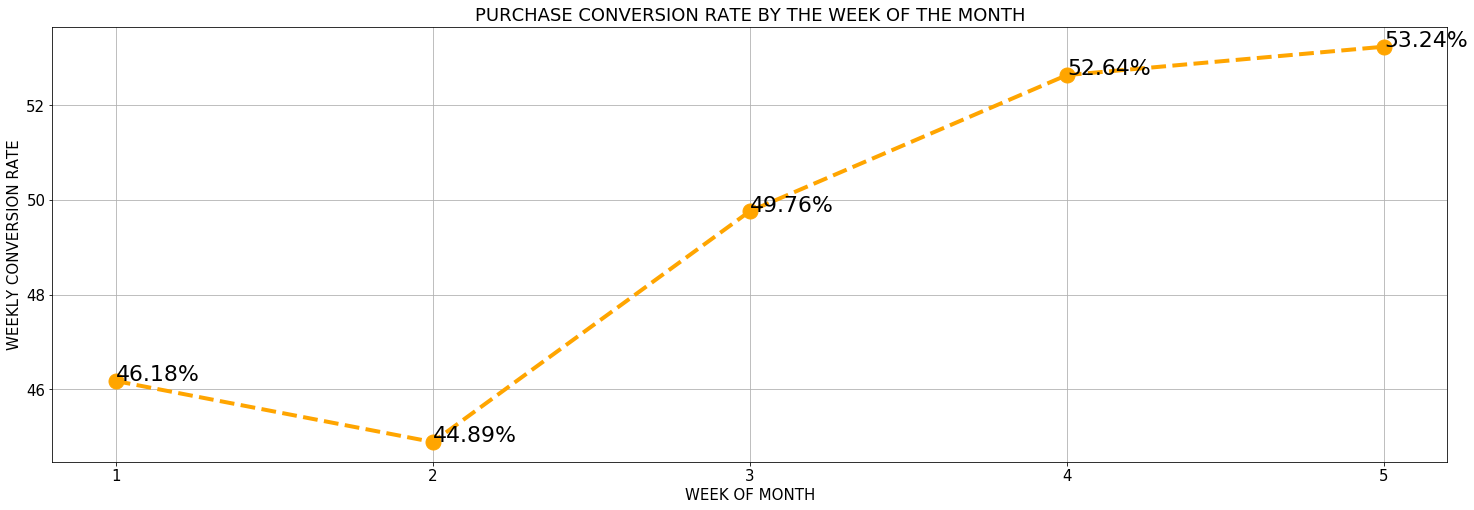

In [115]:
# 월별 매출액 그래프.
plt.rcParams['font.family'] = 'sans-serif' # 폰트 적용
plt.rcParams['font.size'] = 15             # font 크기 조절
plt.figure(figsize=(25, 8))                # 그래프 화면 출력 크기.
plt.plot(weeks, conversions, color='orange', linestyle='--', marker='o', linewidth=4, markersize=15)
show_marker_values(weeks, conversions, 22)
plt.title('PURCHASE CONVERSION RATE BY THE WEEK OF THE MONTH')
plt.xlabel('WEEK OF MONTH')
plt.ylabel('WEEKLY CONVERSION RATE')
plt.xticks(range(1,6))
plt.grid(True)
current_values = plt.gca().get_yticks()
plt.show()

In [ ]:
#############################################
# 9월 주별 구매 전환율 결과 출력                  #
#############################################

In [61]:
september_daily_users = september_users.groupby('day').count()
september_daily_users.rename({'user_idx':'user_count'}, inplace=True, axis=1)

In [62]:
september_daily_users.head(5)

,user_count,status,third_party_join_type,joined_date,month,year,weekofmonth
day,,,,,,,
1,60,60,2,60,60,60,60
2,58,58,2,58,58,58,58
3,51,51,2,51,51,51,51
4,37,37,1,37,37,37,37
5,57,57,3,57,57,57,57


In [128]:
september_daily_conversioned_users = september_conversioned_users.groupby('day').count()
september_daily_conversioned_users.rename({'user_idx':'user_count'}, inplace=True, axis=1)

In [129]:
september_daily_conversioned_users.head(5)

,user_count,status,third_party_join_type,joined_date,month,year,weekofmonth,subscription_type,cart_discount_price,order_shipping_price,order_total_price,paid_date
day,,,,,,,,,,,,
1,31,31,2,31,31,31,31,31,31,31,31,31
2,26,26,1,26,26,26,26,26,26,26,26,26
3,26,26,2,26,26,26,26,26,26,26,26,26
4,13,13,0,13,13,13,13,13,13,13,13,13
5,28,28,2,28,28,28,28,28,28,28,28,28


In [130]:
# 2020년 9월 일별 구매 전환 유저 비율 계산.
september_daily_conversioned_users = (september_daily_conversioned_users['user_count'].count()/september_daily_users['user_count'])*100
september_daily_conversioned_users = september_daily_conversioned_users.reset_index()
september_daily_conversioned_users.rename({'user_count':'conversion rate'}, inplace=True, axis=1)

In [131]:
september_daily_conversioned_users.head()

,day,conversion rate
0,1,50.000000
1,2,51.724138
2,3,58.823529
3,4,81.081081
4,5,52.631579


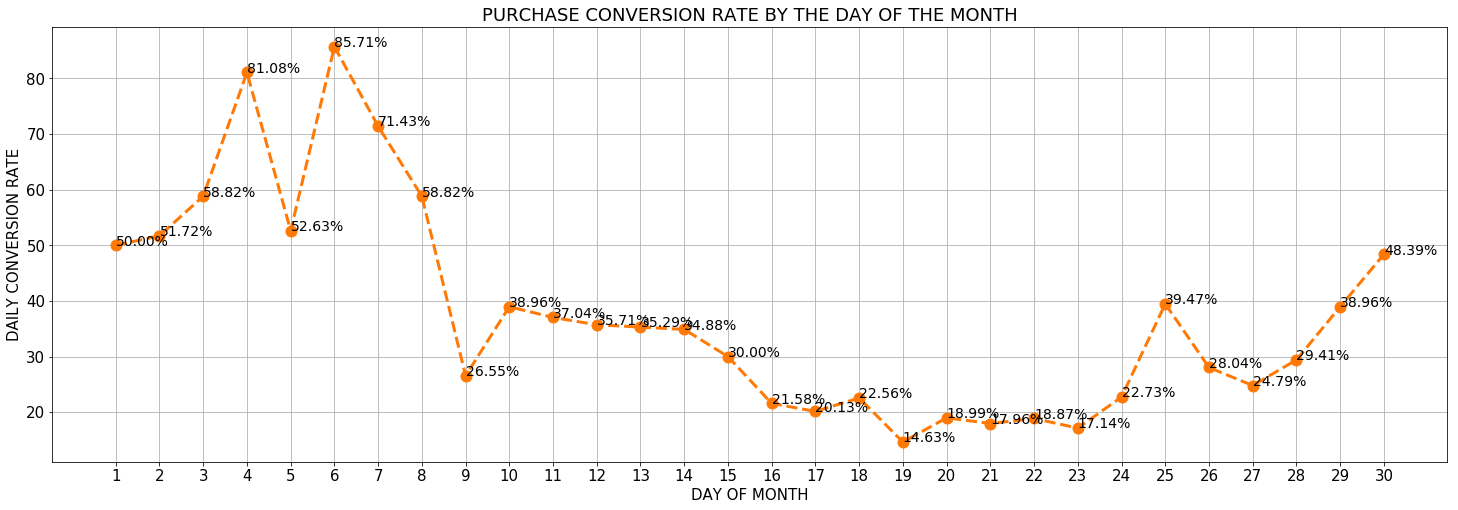

In [134]:
# 월별 매출액 그래프.
plt.rcParams['font.family'] = 'sans-serif' # 폰트 적용
plt.rcParams['font.size'] = 15             # font 크기 조절
plt.figure(figsize=(25, 8))                # 그래프 화면 출력 크기.
plt.plot(september_daily_conversioned_users['day'], september_daily_conversioned_users['conversion rate'], color='#ff7906', linestyle='--', marker='o', linewidth=3, markersize=11)
show_marker_values(september_daily_conversioned_users['day'], september_daily_conversioned_users['conversion rate'], 14)
plt.title('PURCHASE CONVERSION RATE BY THE DAY OF THE MONTH')
plt.xlabel('DAY OF MONTH')
plt.ylabel('DAILY CONVERSION RATE')
plt.xticks(range(1,31))
plt.grid(True)
current_values = plt.gca().get_yticks()
plt.show()